In [1]:
import yaml
import sys
sys.path.append("../")
from plugins.interfaces.diagnostics import AWAFrameGrabberDiagnostic, ROI

# define screen and trim parameters
screen = "DYG5"
magnet_info = yaml.safe_load(open("awa_config/awa_drive_magnet_config.yml"))
screen_info = yaml.safe_load(open("awa_config/awa_drive_camera_config.yml"))[screen]

In [2]:
# create Xopt objects
from xopt import VOCS
IMAGE_CONSTRAINTS = {
            "bb_penalty": ["LESS_THAN", 0.0],
        }

vocs = VOCS(
    variables = {
        "AWA:Bira3Ctrl:Ch03":[-0.75,0.75], # DQ4
        "AWA:Bira3Ctrl:Ch05":[-0.75,0.75], # DQ7
        "AWA:Drive:DT8H_B_S:Ctrl":[-2.1,2.1],
        "AWA:Drive:DT9V_B_N:Ctrl":[-2.1,2.1] # actually horizontal
    },
    constraints = IMAGE_CONSTRAINTS,
    observables = ["Cx"],
)

In [3]:
vocs.variable_names

['AWA:Bira3Ctrl:Ch03',
 'AWA:Bira3Ctrl:Ch05',
 'AWA:Drive:DT8H_B_S:Ctrl',
 'AWA:Drive:DT9V_B_N:Ctrl']

In [4]:
screen_roi = ROI(
    xcenter=int(screen_info["center"][0]),
    ycenter=int(screen_info["center"][1]),
    xwidth=int(screen_info["radius"]*1.5),
    ywidth=int(screen_info["radius"]*1.5),
)

image_diagnostic = AWAFrameGrabberDiagnostic(
    roi=screen_roi, apply_bounding_box_constraint=False, visualize=False,
    threshold=200
)

displaying image
fitting image


{'Cx': 151.3221086626851,
 'Cy': 154.60310018115217,
 'Sx': 8.623456909400327,
 'Sy': 7.75371809004188,
 'bb_penalty': -105.83947074666796,
 'total_intensity': 131960.0,
 'log10_total_intensity': 5.120442306873306}

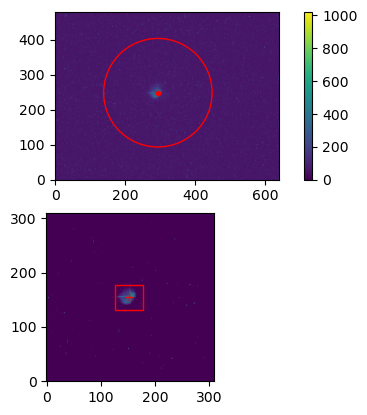

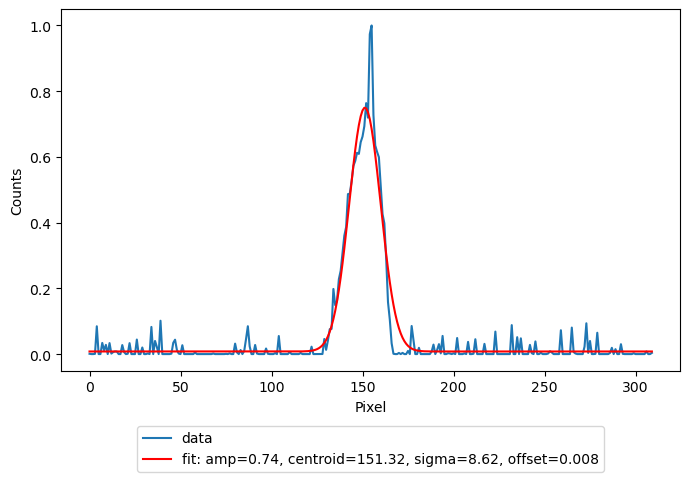

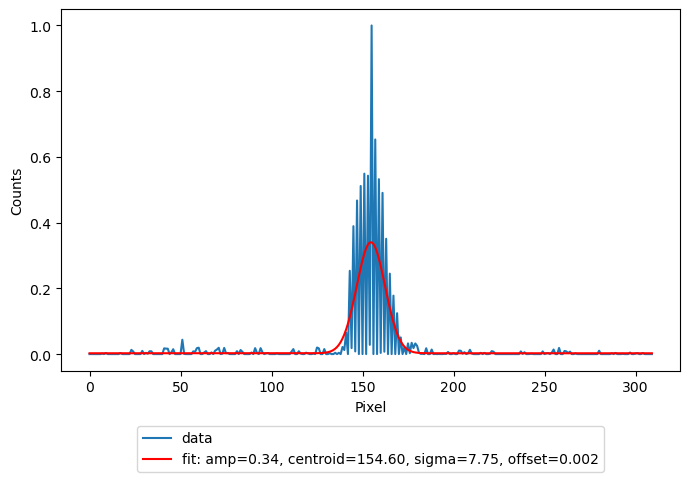

In [5]:
image_diagnostic.test_measurement()

In [6]:
import time
from xopt import Evaluator
from epics import caput

def evaluate(inputs: dict):
    global image_diagnostic
    # caput values
    for name, val in inputs.items():
        caput(name, val)

    # wait for changes to occur - use small wait time for interpolated measurements
    time.sleep(2.0)

    results = image_diagnostic.measure_beamsize(1, **inputs)

    # measure distance to image center
    print(results["Cx"], image_diagnostic.roi.xwidth/2)
    results["center_dist_x"] = results["Cx"] - image_diagnostic.roi.xwidth/2
    results["center_dist_y"] = results["Cy"] - image_diagnostic.roi.ywidth/2

    results["center_dist"] = (results["center_dist_x"]**2 + results["center_dist_y"]**2)**0.5
    results["time"] = time.time()
    
    return results

evaluator = Evaluator(function=evaluate)

In [7]:
from gpytorch.kernels import MaternKernel, PolynomialKernel, ScaleKernel
from xopt.generators.bayesian.models.standard import StandardModelConstructor
from gpytorch.priors.torch_priors import GammaPrior
from xopt.generators.bayesian.bax_generator import BaxGenerator
from xopt.generators.bayesian.bayesian_exploration import BayesianExplorationGenerator
from copy import deepcopy
sys.path.append("../bax/")

from bax_alignment import ScipyBeamAlignment
covar_module = PolynomialKernel(
    power=1, active_dims=[0]
) * PolynomialKernel(
    power=1, active_dims=[1]
) * PolynomialKernel(
    power=1, active_dims=[2]
) * PolynomialKernel(
    power=1, active_dims=[3]
)
scaled_covar_module = ScaleKernel(covar_module)   
    
# prepare options for Xopt generator
covar_module_dict = {'Cx': scaled_covar_module}
# covar_module_dict = {}
model_constructor = StandardModelConstructor(
    covar_modules=covar_module_dict, use_low_noise_prior=True
)

algo = ScipyBeamAlignment(
    meas_dims=[0, 1], 
    n_samples=10, 
    x_key='Cx',
)

generator = BaxGenerator(
    vocs=vocs, 
    gp_constructor=model_constructor, 
    algorithm=algo,
    #n_interpolate_points=5,
)

#generator = BayesianExplorationGenerator(
#    vocs=vocs, 
#    gp_constructor=model_constructor, 
#)

generator.numerical_optimizer.max_time = 10.0


In [8]:
from xopt import Xopt
X = Xopt(vocs=vocs, generator=generator, evaluator=evaluator, strict=False, 
         dump_file="two_quad_x_alignment_smaller_initial_scan.yml")

In [9]:
X


            Xopt
________________________________
Version: 2.2.1+8.g7a7eff90.dirty
Data size: 0
Config as YAML:
dump_file: two_quad_x_alignment_smaller_initial_scan.yml
evaluator:
  function: __main__.evaluate
  function_kwargs: {}
  max_workers: 1
  vectorized: false
generator:
  algorithm:
    n_samples: 10
  algorithm_results_file: null
  computation_time: null
  fixed_features: null
  gp_constructor:
    covar_modules: {}
    mean_modules: {}
    name: standard
    trainable_mean_keys: []
    transform_inputs: true
    use_low_noise_prior: true
  log_transform_acquisition_function: false
  max_travel_distances: null
  model: null
  n_candidates: 1
  n_interpolate_points: null
  n_monte_carlo_samples: 128
  name: BAX
  numerical_optimizer:
    max_iter: 2000
    max_time: 10.0
    n_restarts: 20
    name: LBFGS
  turbo_controller: null
  use_cuda: false
max_evaluations: null
serialize_inline: false
serialize_torch: false
strict: false
vocs:
  constants: {}
  constraints:
    bb_pen

In [10]:
from epics import caget_many
from xopt.utils import get_local_region
import pandas as pd
import numpy as np

# create a mesh
n_samples = 3
xx = np.meshgrid(
    np.linspace(-0.25, 0.25,2),
    np.linspace(-0.25, 0.25,2),
    np.linspace(-0.25, 0.25,2),
    np.linspace(-0.25, 0.25,2)
)
pts = np.vstack([ele.flatten() for ele in xx])
print(len(pts))
X.evaluate_data({
    "AWA:Bira3Ctrl:Ch03":pts[0],
    "AWA:Bira3Ctrl:Ch05":pts[1],
    "AWA:Drive:DT8H_B_S:Ctrl":pts[2],
    "AWA:Drive:DT9V_B_N:Ctrl":pts[3]
}
)

#X.random_evaluate(2)#, custom_bounds=random_sample_region)

{'AWA:Bira3Ctrl:Ch03': 0.0, 'AWA:Bira3Ctrl:Ch05': 0.0, 'AWA:Drive:DT8H_B_S:Ctrl': 0.0, 'AWA:Drive:DT9V_B_N:Ctrl': 0.0}
4


CA.Client.Exception...............................................
    Context: "Channel: "AWANIFG:ImgData", Connecting to: 192.168.0.2:62521, Ignored: 192.168.2.57:62521"
    Source File: ../cac.cpp line 1320
    Current Time: Fri Mar 15 2024 09:19:26.706222442
..................................................................
CA.Client.Exception...............................................
    Context: "Channel: "AWANIFG:ImgData", Connecting to: 192.168.0.2:62521, Ignored: awa3.hep.anl.gov:62521"
    Source File: ../cac.cpp line 1320
    Current Time: Fri Mar 15 2024 09:19:26.707146660
..................................................................


fitting image
153.4382112988458 155.0
fitting image
118.18469489845509 155.0
fitting image
193.15215073471313 155.0
fitting image
158.92035512822312 155.0
fitting image
148.42148386585478 155.0
fitting image
112.5621326366252 155.0
fitting image
198.06009597537192 155.0
fitting image
161.5657580159997 155.0
fitting image
142.99948974636865 155.0
fitting image
104.76514076721841 155.0
fitting image
199.55276843742237 155.0
fitting image
157.7834749187523 155.0
fitting image
140.17306481089497 155.0
fitting image
95.08121036849143 155.0
fitting image
208.13347559607266 155.0
fitting image
160.92995070619742 155.0


,AWA:Bira3Ctrl:Ch03,AWA:Bira3Ctrl:Ch05,AWA:Drive:DT8H_B_S:Ctrl,AWA:Drive:DT9V_B_N:Ctrl,Cx,Cy,Sx,Sy,bb_penalty,total_intensity,log10_total_intensity,center_dist_x,center_dist_y,center_dist,time,xopt_runtime,xopt_error
0,-0.25,-0.25,-0.25,-0.25,153.438211,132.598532,4.923678,13.389173,-90.864585,126107.0,5.100739,-1.561789,-22.401468,22.455845,1.710512e+09,3.385473,False
1,-0.25,-0.25,-0.25,0.25,118.184695,133.772362,4.910465,13.849124,-64.655742,132719.0,5.122933,-36.815305,-21.227638,42.496815,1.710512e+09,3.328506,False
2,-0.25,-0.25,0.25,-0.25,193.152151,133.950688,5.506030,11.932065,-120.277287,105503.0,5.023265,38.152151,-21.049312,43.573617,1.710512e+09,3.481124,False
3,-0.25,-0.25,0.25,0.25,158.920355,132.766912,5.291786,13.057024,-94.762578,120110.0,5.079579,3.920355,-22.233088,22.576080,1.710512e+09,3.264613,False
4,0.25,-0.25,-0.25,-0.25,148.421484,155.720979,10.036124,5.504112,-104.206247,98292.0,4.992518,-6.578516,0.720979,6.617906,1.710512e+09,3.565908,False
5,0.25,-0.25,-0.25,0.25,112.562133,156.327129,9.273774,7.424107,-72.607083,135419.0,5.131680,-42.437867,1.327129,42.458613,1.710512e+09,3.768855,False
6,0.25,-0.25,0.25,-0.25,198.060096,154.366081,8.260171,4.480537,-149.381984,63608.0,4.803512,43.060096,-0.633919,43.064762,1.710512e+09,3.279356,False
7,0.25,-0.25,0.25,0.25,161.565758,155.687462,10.211782,5.550786,-114.705606,99153.0,4.996306,6.565758,0.687462,6.601650,1.710512e+09,3.321847,False
8,-0.25,0.25,-0.25,-0.25,142.999490,147.116092,9.342861,6.348999,-95.342646,74869.0,4.874302,-12.000510,-7.883908,14.358560,1.710512e+09,3.494089,False
9,-0.25,0.25,-0.25,0.25,104.765141,148.382507,8.924404,7.369469,-62.925790,101495.0,5.006445,-50.234859,-6.617493,50.668849,1.710512e+09,3.324680,False


/home/awa/awa-badger/control_notebooks/../bax/bax_alignment.py:337: UserWarning: torch.cholesky is deprecated in favor of torch.linalg.cholesky and will be removed in a future PyTorch release.
L = torch.cholesky(A)
should be replaced with
L = torch.linalg.cholesky(A)
and
U = torch.cholesky(A, upper=True)
should be replaced with
U = torch.linalg.cholesky(A).mH().
This transform will produce equivalent results for all valid (symmetric positive definite) inputs. (Triggered internally at ../aten/src/ATen/native/BatchLinearAlgebra.cpp:1691.)
  Lnn = torch.cholesky(K.to_dense())
/home/awa/awa-badger/control_notebooks/../bax/bax_alignment.py:194: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at ../aten/src/ATen/native/TensorShape.c

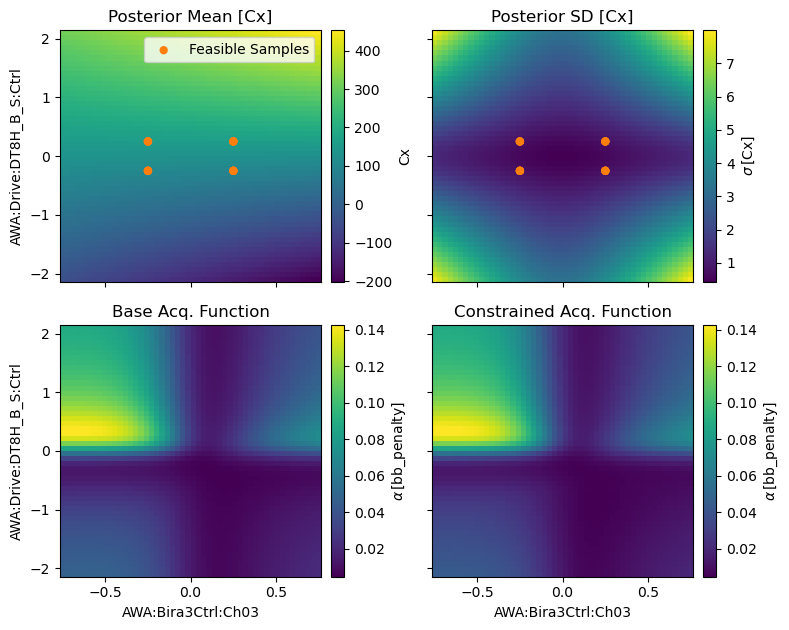

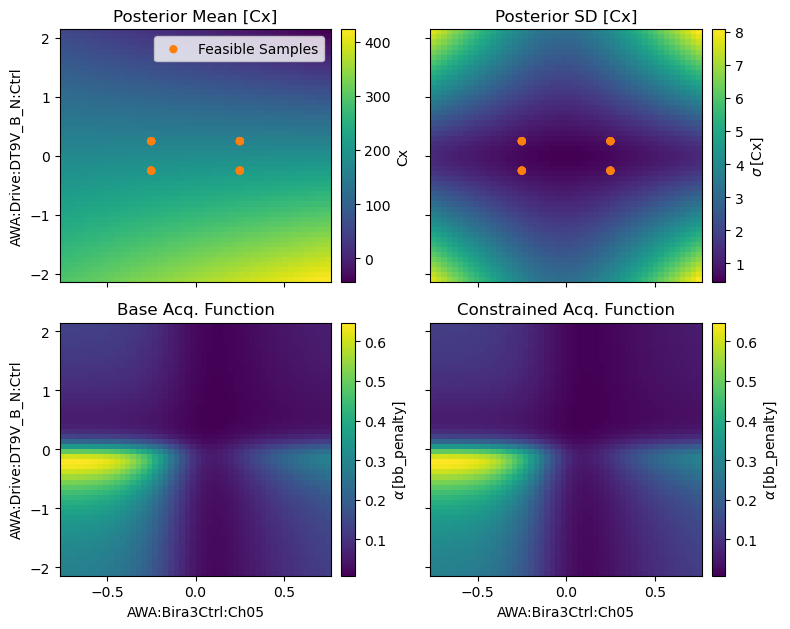

In [11]:
from xopt.generators.bayesian.visualize import visualize_generator_model
X.generator.train_model()
fig,ax = visualize_generator_model(
    X.generator, 
    variable_names=["AWA:Bira3Ctrl:Ch03","AWA:Drive:DT8H_B_S:Ctrl"],
    output_names=["Cx"]
)

fig,ax = visualize_generator_model(
    X.generator, 
    variable_names=["AWA:Bira3Ctrl:Ch05","AWA:Drive:DT9V_B_N:Ctrl"],
    output_names=["Cx"]
)

#X_stars = X.generator.algorithm_results["X_stars"]
#for ele in X_stars:
#    ax[0,0].axhline(ele,c="C3", xmax=0.1)


In [12]:
for i in range(10):
    X.step()

fitting image
186.1117345300099 155.0
fitting image
193.37529711400364 155.0
fitting image
179.88726080972876 155.0
fitting image
216.56357920476725 155.0
fitting image
204.93358885884962 155.0
fitting image
69.8953235975011 155.0
fitting image
191.7390231721148 155.0
fitting image
184.34832153745418 155.0
fitting image
185.5950055811194 155.0
fitting image
177.83608374812817 155.0


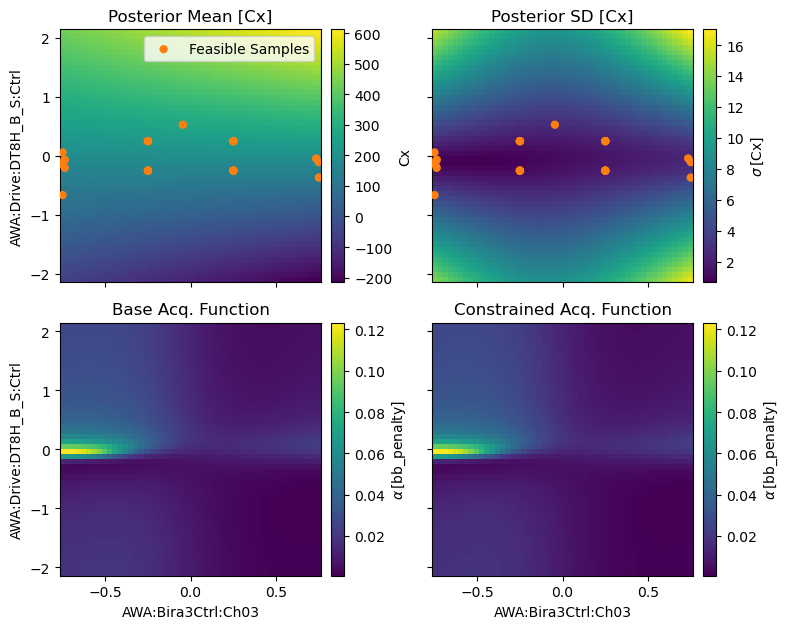

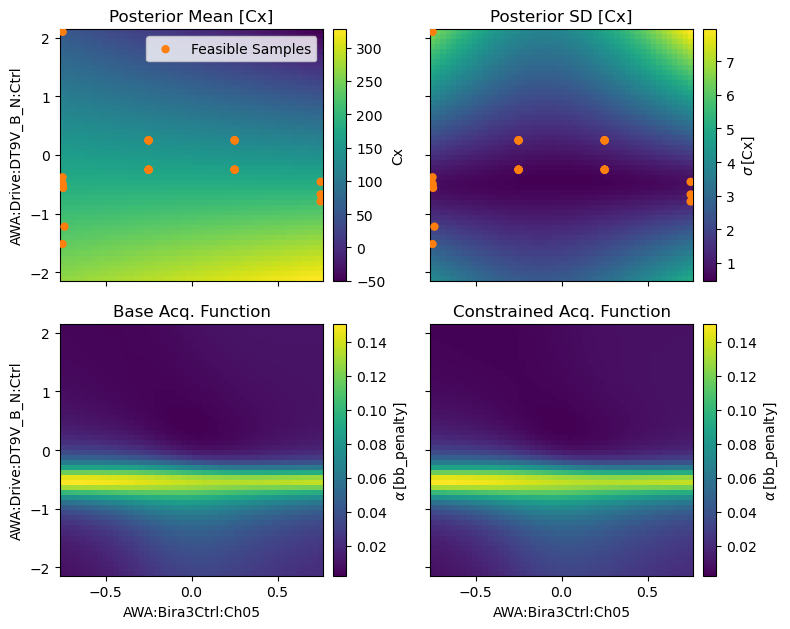

In [13]:
X.generator.train_model()
fig,ax = visualize_generator_model(
    X.generator, 
    variable_names=["AWA:Bira3Ctrl:Ch03","AWA:Drive:DT8H_B_S:Ctrl"],
    output_names=["Cx"]
)

fig,ax = visualize_generator_model(
    X.generator, 
    variable_names=["AWA:Bira3Ctrl:Ch05","AWA:Drive:DT9V_B_N:Ctrl"],
    output_names=["Cx"]
)


In [15]:
from xopt.generators.bayesian.visualize import visualize_generator_model

fig,ax = visualize_generator_model(
    X.generator, 
    variable_names=["AWA:Bira3Ctrl:Ch03"],
    reference_point={"AWA:Drive:DT8H_B_S:Ctrl":0.25},
    output_names=["Cx"]
)

fig2,ax2 = visualize_generator_model(
    X.generator, 
    variable_names=["AWA:Bira3Ctrl:Ch03"],
    reference_point={"AWA:Drive:DT8H_B_S:Ctrl":1.0},
    output_names=["Cx"]
)

fig3,ax3 = visualize_generator_model(
    X.generator, 
    variable_names=["AWA:Bira3Ctrl:Ch03"],
    reference_point={"AWA:Drive:DT8H_B_S:Ctrl":1.1},
    output_names=["Cx"]
)

KeyError: 'AWA:Bira3Ctrl:Ch05'

In [ ]:
from xopt.generators.bayesian.visualize import visualize_generator_model
X.generator.train_model()
fig,ax = visualize_generator_model(
    X.generator, 
    variable_names=["AWA:Bira3Ctrl:Ch03","AWA:Drive:DT8H_B_S:Ctrl"],
    output_names=["Cx"]
)
#X_stars = X.generator.algorithm_results["X_stars"]
#for ele in X_stars:
#    ax[0,0].axhline(ele,c="C3", xmax=0.1)
